In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import cvxpy
from pykalman import KalmanFilter

from operator import itemgetter

In [3]:
%matplotlib notebook

# Setup

#### Utility functions

In [4]:
def sample_data(getter, original_data, data_keys):
    sampled_data = {}
    for key in data_keys:
        # print key, original_data[key].shape
        sampled_data[key] = np.array(getter(original_data[key].T)).T
    return sampled_data

In [5]:
def sharpe_ratio(S):
    returns = np.diff(S) / S[:-1]
    sr = np.mean(returns) / np.std(returns)
    return sr * np.sqrt(252)

#### Load data & transform to data matrices with dims `[NUM_STOCKS, TIME]`

In [6]:
data = loadmat('portfolio.mat')
keys = ['hi', 'lo', 'open', 'close', 'vol']

all_data = {}
all_data['lo'] = np.nan_to_num(data['train_lo'].T)
all_data['hi'] = np.nan_to_num(data['train_hi'].T)
all_data['open'] = np.nan_to_num(data['train_op'].T)
all_data['close'] = np.nan_to_num(data['train_cl'].T)
all_data['vol'] = np.nan_to_num(data['train_vol'].T)
all_data['stocks'] = np.array([entry[0] for entry in data['train_stocks'][0]])
NUM_STOCKS = all_data['stocks'].shape[0]
TIME = all_data['open'].shape[1]

#### Split the dataset

In [7]:
NUM_TRAIN = 900
NUM_TEST = TIME - NUM_TRAIN

In [8]:
permuted_stocks = range(TIME)
get_train = itemgetter(*permuted_stocks[:NUM_TRAIN])
get_test = itemgetter(*permuted_stocks[NUM_TRAIN:TIME])

train_data = sample_data(get_train, all_data, keys)
test_data = sample_data(get_test, all_data, keys)

train_data['close'] = np.nan_to_num(train_data['close'])
test_data['close'] = np.nan_to_num(test_data['close'])

print train_data['close'].shape
print test_data['close'].shape

(497, 900)
(497, 347)


# Framework

In [9]:
def simulate(init_portfolio, strategy, dataset):
    
    time = dataset.shape[1]
    
    # initialize
    b = np.zeros([NUM_STOCKS, time])
    x = np.zeros([NUM_STOCKS, time])
    S = np.zeros(time)
    
    b[:, 0] = init_portfolio
    S[0] = 1
    x[:, 0] = np.ones([1, NUM_STOCKS])
    
    # main loop
    for t in range(1, time):
        
        # compute next x values
        zero_locs = np.where(dataset[:, t-1] == 0)[0]
        nonzero_locs = np.where(dataset[:, t-1] != 0)[0]
        
        x[zero_locs, t] = 1
        x[nonzero_locs, t] = dataset[nonzero_locs, t] / dataset[nonzero_locs, t-1]
        
        # update wealth according to market
        S[t] = S[t-1]*np.dot(x[:, t], b[:, t-1])
        
        # update portfolio values according to market changes and renormalize
        b[:,t-1] = b[:, t-1] * x[:, t] / np.dot(b[:, t-1],x[:, t])
         
        # compute new portfolio
        b[:, t] = strategy(b, x, t)
        
        # compute transaction costs
        trans_cost = S[t]*np.sum(np.absolute(b[:, t] - b[:, t-1])) * .0005
        
        # update wealth according to transaction costs
        S[t] = S[t] - trans_cost
        
    return b, x, S

In [10]:
def strategy(portfolio, dataset, timestep, extra_params = {}):
    pass

In [11]:
unif_init = 1./NUM_STOCKS * np.ones(NUM_STOCKS)

# Baselines

#### Buy And Hold

In [12]:
def BAH(b, x, t):
    return b[:, t-1]

b, x, S = simulate(unif_init, BAH, test_data['close'])
print S[-1]
print sharpe_ratio(S)

1.3680321842
1.32067378845


#### Constant Rebalanced Portfolio

In [13]:
def CRP(b, x, t):
    return b[:, 0]

b, x, S = simulate(unif_init, CRP, test_data['close'])
print S[-1]
print sharpe_ratio(S)

1.37342159038
1.35276852148


# Other Algorithms

#### Exponential Gradient

In [14]:
def EG(b, x, t):
    eta = 1e-2
    
    b_opt = cvxpy.Variable(NUM_STOCKS)
    objective = cvxpy.Minimize(cvxpy.pnorm(b_opt - b[:,t-1], 2) -
                eta * cvxpy.log(cvxpy.sum_entries(x[:, t-1] * b_opt)))
    constraints = [cvxpy.sum_entries(b_opt) == 1., b_opt <= 1., b_opt >= -1.]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve(verbose=False, solver='SCS')
    
    ret = np.transpose(b_opt.value)
    ret /= np.sum(ret)
    
    return ret

b, x, S = simulate(unif_init, EG, test_data['close'])
print S[-1]
print sharpe_ratio(S)

1.37010139226
1.34049936931


#### Markowitz

In [15]:
# data
dataset = train_data['close']

# params
window_size = 50 # sliding window
mu = 1e-1 # risk-reward ratio

# initialization
p_init = np.zeros([NUM_STOCKS, NUM_TRAIN])

# fix holes in train data
for t in range(1, NUM_TRAIN):
        
    zero_locs = np.where(dataset[:, t-1] == 0)[0]
    nonzero_locs = np.where(dataset[:, t-1] != 0)[0]
        
    p_init[zero_locs, t] = 0
    p_init[nonzero_locs, t] = (dataset[nonzero_locs, t] - dataset[nonzero_locs, t-1]) / dataset[nonzero_locs, t-1]
    
# compute statistics
pbar = np.mean(p_init[:, -window_size:], axis=1)
sigma = np.cov(p_init[:, -window_size:])

# solve markowitz problem
b_init = cvxpy.Variable(NUM_STOCKS)
objective = cvxpy.Minimize(-pbar*b_init + mu*cvxpy.quad_form(b_init, sigma + np.eye(NUM_STOCKS)))
constraints = [cvxpy.sum_entries(b_init) == 1.]
problem = cvxpy.Problem(objective, constraints)
problem.solve(verbose=False, solver='SCS')

# renormalize to fix numerical issues
b_init = np.transpose(b_init.value)
b_init /= np.sum(b_init)

# BAH
b, x, S = simulate(b_init, BAH, test_data['close'])
print S[-1]
print sharpe_ratio(S)

# CRP
b, x, S = simulate(b_init, CRP, test_data['close'])
print S[-1]
print sharpe_ratio(S)

1.53344207682
1.73747710292
1.50246518433
1.69725122239


In [1]:
# params
window_size = 450 # sliding window
mu = 1e-1 # risk-reward ratio
eta = 1e-3 # regularization for error

def markowitz(b, x, t):
    
    #print t,
    
    # data
    dataset = test_data['close']
    
    # initialization
    p = np.zeros([NUM_STOCKS, t])
    
    # fix holes in train data
    for curr_t in range(1, t):    
        zero_locs = np.where(dataset[:, curr_t-1] == 0)[0]
        nonzero_locs = np.where(dataset[:, curr_t-1] != 0)[0]
        
        p[zero_locs, curr_t] = 0
        p[nonzero_locs, curr_t] = (dataset[nonzero_locs, curr_t] - dataset[nonzero_locs, curr_t-1]) / dataset[nonzero_locs, curr_t-1]
    
    # compute statistics
    pbar = np.mean(np.hstack([p_init, p])[:, t+NUM_TRAIN-window_size:t+NUM_TRAIN-1] , axis=1)
    sigma = np.cov(np.hstack([p_init, p])[:, t+NUM_TRAIN-window_size:t+NUM_TRAIN-1])
    
    b_opt = cvxpy.Variable(NUM_STOCKS)
    objective = cvxpy.Minimize(-pbar*b_opt + mu*cvxpy.quad_form(b_opt, sigma + np.eye(NUM_STOCKS))
                + eta*cvxpy.pnorm(b_opt - b[:,t-1], 2))
    constraints = [cvxpy.sum_entries(b_opt) == 1.]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve(verbose=False, solver='SCS')
                           
    b_opt = np.transpose(b_opt.value)
    b_opt /= np.sum(b_opt)
    
    return b_opt

best_sharpe_ratio = 0.0
best_window_size = None
for window_size in [50 * _ for _ in range(1, 11)]:
    _, _, S = simulate(b_init, markowitz, test_data['close'])
    if sharpe_ratio(S) > best_sharpe_ratio:
        best_sharpe_ratio = sharpe_ratio(S)
        best_window_size = window_size
    print "SHARPE RATIO:"
    print window_size, sharpe_ratio(S)

print "BEST SHARPE RATIO:"
print best_window_size, best_sharpe_ratio

NameError: name 'simulate' is not defined

In [49]:
best_sharpe_ratio = 0.0
best_window_size = None
for window_size in [425 + (5 * _) for _ in range(1, 11)]:
    _, _, S = simulate(b_init, markowitz, test_data['close'])
    if sharpe_ratio(S) > best_sharpe_ratio:
        best_sharpe_ratio = sharpe_ratio(S)
        best_window_size = window_size
    print "SHARPE RATIO:"
    print window_size, sharpe_ratio(S)

print "BEST SHARPE RATIO:"
print best_window_size, best_sharpe_ratio

SHARPE RATIO:
430 1.3026017295
SHARPE RATIO:
435 1.39913845267
SHARPE RATIO:
440 1.44011989286
SHARPE RATIO:
445 1.45145430166
SHARPE RATIO:
450 1.45286104724
SHARPE RATIO:
455 1.4257784918
SHARPE RATIO:
460 1.42161704896
SHARPE RATIO:
465 1.42775430374
SHARPE RATIO:
470 1.40705139345
SHARPE RATIO:
475 1.35026992821
BEST SHARPE RATIO:
450 1.45286104724


# Kalman Filter

In [14]:
def causal_kf(kf, dataset):
    
    means = [np.ones(NUM_STOCKS)]
    covariances = [np.eye(NUM_STOCKS)]
    
    for t in range(1,NUM_TRAIN):
        
        next_mean, next_covariance = kf.filter_update(means[-1], covariances[-1], dataset[:, t])
        means.append(next_mean)
        covariances.append(next_covariance)
        
    return means, covariances

kf = KalmanFilter(transition_matrices=np.eye(NUM_STOCKS),
                  observation_matrices=np.eye(NUM_STOCKS),
                  initial_state_mean=np.ones(NUM_STOCKS),
                  initial_state_covariance=np.eye(NUM_STOCKS),
                  observation_covariance=np.eye(NUM_STOCKS),
                  transition_covariance=0.1*np.eye(NUM_STOCKS))

means, variances = causal_kf(kf, train_data['close'])

data = train_data['close']
kalman = np.vstack(means).T

Look [here](https://pykalman.github.io/) for the Kalman filter API. Note that `kalman` has the same shape as `train_data['close']` 

<IPython.core.display.Javascript object>


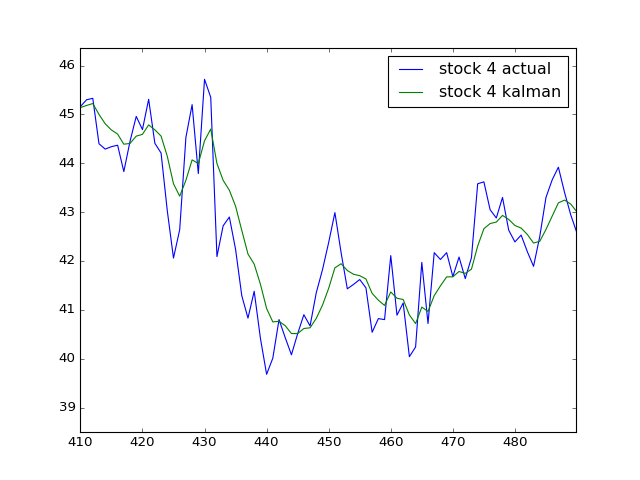

In [16]:
plt.figure()
plt.plot(data[23,:], label='stock 4 actual')
plt.plot(kalman[23,:], label='stock 4 kalman')
plt.legend(loc='best')
plt.show()

In [45]:
[50 * _ for _ in range(1, 11)]

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]